In [2]:
import os
from collections import Counter
import torch
import torch.nn as nn
from fastai.metrics import FBeta
from fastai.vision.learner import cnn_learner
from fastai.metrics import accuracy
from fastai.losses import CrossEntropyLossFlat
from fastai.vision.learner import vision_learner
from fastai.callback.mixup import MixUp,CutMix
from fastai.vision.learner import model_meta
from fastai.vision.all import *
#early stopping to prevent overfitting
from torchvision.models import *  # import *=all the models from torchvision  
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback
from fastai.callback.progress import ShowGraphCallback

from functools import partial
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import shutil
import joblib
import seaborn as sns
# import pretrainedmodels
from sklearn.metrics import (average_precision_score, 
                             balanced_accuracy_score, 
                             classification_report, 
                             f1_score, 
                             confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             roc_auc_score)


from tqdm import tqdm_notebook
print("libraries are imported")

libraries are imported


In [3]:
dataset_path = "/kaggle/input/dental-images/dental_data"

In [4]:

loss_dict = {
    'cross_entropy': CrossEntropyLossFlat(),
    'mse': torch.nn.MSELoss(),
    'mae': torch.nn.L1Loss()
}
config = {
    'transforms': dict(
        do_flip=True, 
        flip_vert=False,
        max_rotate=10.0, 
        max_zoom=1.1, 
        max_lighting=0.2, 
        max_warp=0.2, 
        p_affine=0.75, 
        p_lighting=0.75
    ),
    'pretrained': True,
    'arch': "xception",
    'loss': "cross_entropy",
    'dropout': 0.5,
    'mixup': True,
    'cutmix': False,
    #call_back fucntions
    'earlystop': False,
    'over_sampling': False,
    
    'max_lr': 1e-2,
    'weight_decay': 1e-2,
    'batch_size': 32,
    'image_size': 224
}

In [5]:
def model_config():
    model_used = config['arch'] + '/' + config['loss']
    if(config['mixup']):
        model_used += "/mixup"
    if(config['cutmix']):
        model_used += "/cutmix" 
    if(config['over_sampling']):
        model_used += "/over_sampling"
    return model_used

model_used = model_config()

print("Configuration used is : "  + model_used)
config['model_str'] = model_used

Configuration used is : xception/cross_entropy/mixup


In [6]:

def load_image_paths(dataset_path, valid_extensions=(".jpg", ".jpeg", ".png")):
    image_paths = []
    labels = []
    dataset_path = os.path.abspath(dataset_path)
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)

                if os.path.isfile(image_path) and image_file.lower().endswith(valid_extensions):
                    relative_path = os.path.relpath(image_path, dataset_path)
                    image_paths.append(f"/{relative_path}") 
                    labels.append(class_name)

    return np.array(image_paths), np.array(labels)

image_paths, labels = load_image_paths(dataset_path)


In [7]:
import re

def remove_extra_occurrence(paths, substr):
    new_paths = []
    pattern = f"({re.escape(substr)}){{2,}}"
    for idx, path in enumerate(paths):
        if re.search(pattern, path):
            print(f"Double occurrence found at index: {idx}")
            new_path = re.sub(pattern, substr, path)
        else:
            new_path = path
        new_paths.append(new_path)
    return new_paths

substr = '/kaggle/input/dental-images/dental_data'
image_paths = remove_extra_occurrence(image_paths, substr)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


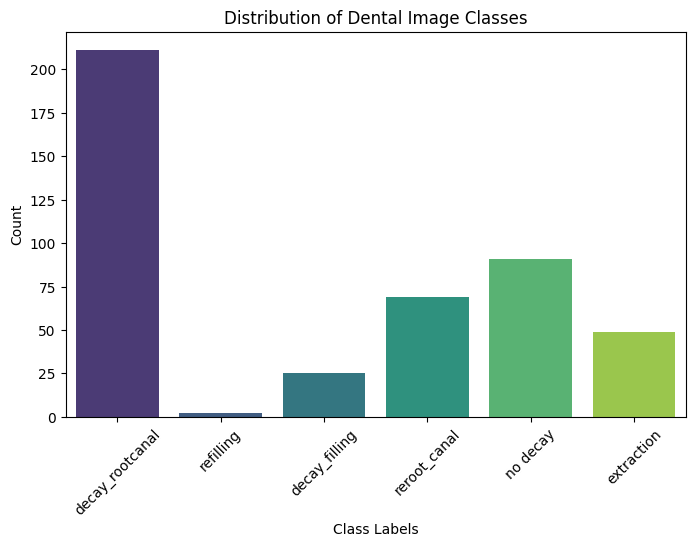

In [8]:

label_counts = Counter(labels)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Distribution of Dental Image Classes")
plt.xticks(rotation=45)
plt.show()

In [9]:

from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(stratified_split.split(image_paths, labels))
image_paths = np.array(image_paths)
labels = np.array(labels)

train_paths, train_labels = image_paths[train_idx].tolist(), labels[train_idx].tolist()
val_paths, val_labels = image_paths[val_idx].tolist(), labels[val_idx].tolist()

# Convert to DataFrame
train_df = pd.DataFrame({'Image': train_paths, 'Class': train_labels})
val_df = pd.DataFrame({'Image': val_paths, 'Class': val_labels})


In [10]:


imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

data = None

def get_data_bunch(reload=False, n_workers=4):
    global data
    if reload: 
        data = None 
    tfms = aug_transforms(**config['transforms']) 
    if data is None:
        data = ImageDataLoaders.from_df(
            train_df, 
            path=dataset_path, 
            valid_pct=0.1, seed=42, 
            label_col='Class', 
            item_tfms=Resize(config['image_size']), 
            batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],
            bs=config['batch_size'], 
            num_workers=n_workers
        )
    return data 




In [11]:

def get_callback_fns(save_callback_flag):
    callback_fns = [ShowGraphCallback]
    if save_callback_flag:
        callback_fns.append(partial(SaveModelCallback, 
                            monitor='fbeta_score', 
                            fname=config['model_str'] + "_best_model"))

    if config.get('earlystop', False):  
        callback_fns.append(partial(EarlyStoppingCallback, 
                                    monitor='f_beta', 
                                    patience=5)) 

    if config.get('over_sampling', False):
        callback_fns.append(partial(OverSamplingCallback))

    return callback_fns


In [12]:

def getLearner(reload_data=False, saved_file=None, save_callback_flag=True,wd = 1e-4):
    data = get_data_bunch(reload=reload_data)
    callback_fns = get_callback_fns(save_callback_flag)
    
    f1_score = FBeta(beta=1, average="weighted")
    
    learner = vision_learner(data, densenet121, 
                             pretrained=config['pretrained'], 
                             path='.', 
                             metrics=[accuracy, f1_score], 
                             ps=config['dropout'], 
                             loss_func=loss_dict[config['loss']],
                             
                             wd = wd)
    
    for cb in callback_fns:
        learner.add_cb(cb())

    if saved_file is not None:
        learner.load(saved_file)
        if reload_data:
            learner.dls = data 
    
    if config.get('mixup', False):
        learner.add_cb(MixUp(alpha=0.4))
    if config.get('cutmix', False):  
        learner.add_cb(CutMix(alpha=1.0))
    
    return learner

TRAINING

FIND THE LR

In [13]:
def find_optimal_lr(wds):
    iter_count = 600
    lrs,losses = [],[]

    for wd in wds:
        learner = getLearner(reload_data=False, saved_file=None, save_callback_flag=False,wd=wd)
        learner.lr_find( num_it=iter_count)
        lrs.append(learner.recorder.lrs)
        losses.append(learner.recorder.losses)
        print(f"LR search done for wd={wd}")
    return lrs, losses

In [14]:
def plot_lr_vs_loss(lrs, losses, wds):
    plt.figure(figsize=(8,6))
    min_y = min([min(loss) for loss in losses]) - 0.02
    max_y = max([max(loss) for loss in losses]) + 0.02  # Adjust margin for better visualization
    
    for i, wd in enumerate(wds):
        plt.plot(lrs[i], losses[i], label=f"WD={wd}")

    plt.ylabel("Loss")
    plt.xlabel("Learning Rate")
    plt.xscale('log')
    plt.ylim(min_y, max_y)  # Dynamically adjust y-axis
    plt.title("Learning Rate Finder Results")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))  # Scientific notation for x-axis
    
    plt.show()

/usr/local/lib/python3.10/dist-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s] 


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

LR search done for wd=1e-06


LR search done for wd=0.0001


LR search done for wd=0.01


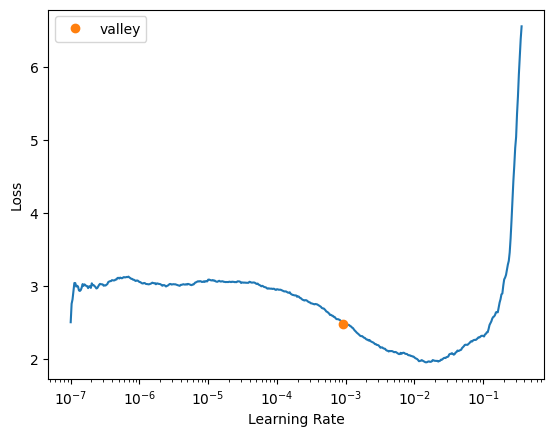

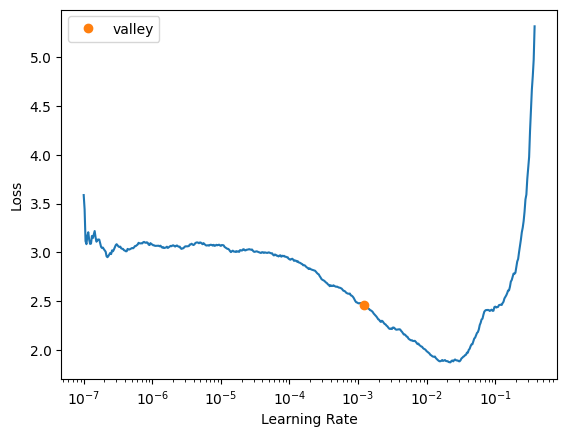

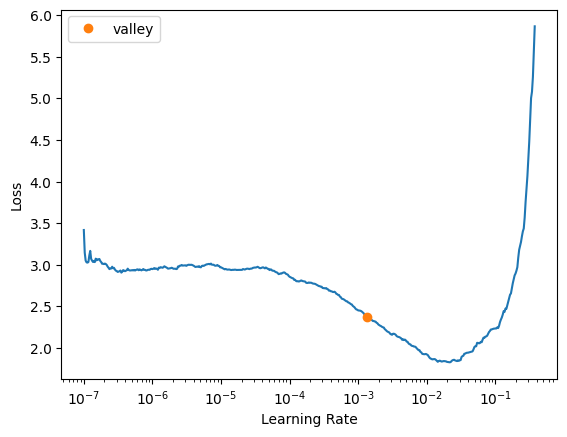

In [15]:
wds = [1e-6,1e-4,1e-2]
lrs,losses = find_optimal_lr(wds)


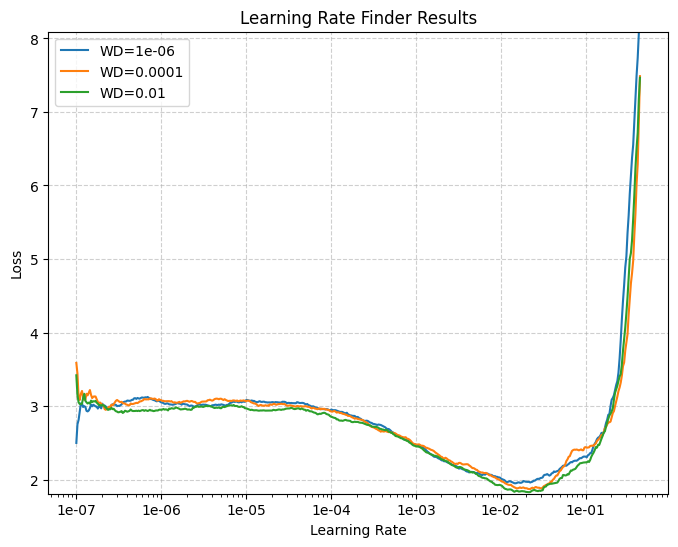

In [16]:
plot_lr_vs_loss(lrs,losses,wds)

In [17]:
config['max_lr'] = max_lr =  1e-2 
config['weight_decay'] =  wd = 1e-4

In [18]:
save_dir = "/kaggle/working/models/xception/cross_entropy"
os.makedirs(save_dir, exist_ok=True)


epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,2.815217,1.793783,0.275000,0.305365,00:07
1,2.728196,3.598043,0.450000,0.340755,00:09
2,2.612333,2.064055,0.475000,0.356699,00:09
3,2.389518,1.889191,0.450000,0.420887,00:08
4,2.179308,1.306563,0.525000,0.443789,00:10
5,2.009423,1.292789,0.525000,0.446154,00:10
6,1.876162,1.091118,0.625000,0.571429,00:10
7,1.736448,1.350535,0.550000,0.502941,00:10
8,1.625548,1.220071,0.575000,0.497311,00:10
9,1.539803,1.210236,0.575000,0.531831,00:10


Better model found at epoch 0 with fbeta_score value: 0.30536522301228186.


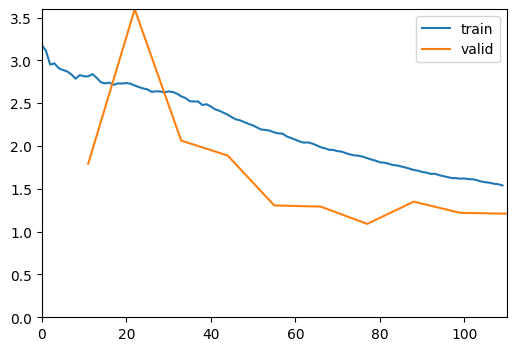

Better model found at epoch 1 with fbeta_score value: 0.3407547169811321.
Better model found at epoch 2 with fbeta_score value: 0.35669856459330146.
Better model found at epoch 3 with fbeta_score value: 0.4208874458874459.
Better model found at epoch 4 with fbeta_score value: 0.4437893081761007.
Better model found at epoch 5 with fbeta_score value: 0.4461538461538462.
Better model found at epoch 6 with fbeta_score value: 0.5714285714285714.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,1.303834,1.032875,0.675000,0.634762,00:10
1,1.288417,1.372990,0.625000,0.548585,00:10
2,1.353697,1.803997,0.450000,0.393310,00:10
3,1.422321,1.856476,0.425000,0.336667,00:10
4,1.448873,2.050596,0.400000,0.372418,00:10
5,1.462125,1.465686,0.475000,0.387826,00:10
6,1.470774,1.395795,0.500000,0.431939,00:10
7,1.414137,1.535917,0.525000,0.467184,00:09
8,1.362569,1.342285,0.525000,0.488636,00:10
9,1.304323,1.347884,0.550000,0.511364,00:10


Better model found at epoch 0 with fbeta_score value: 0.6347619047619047.


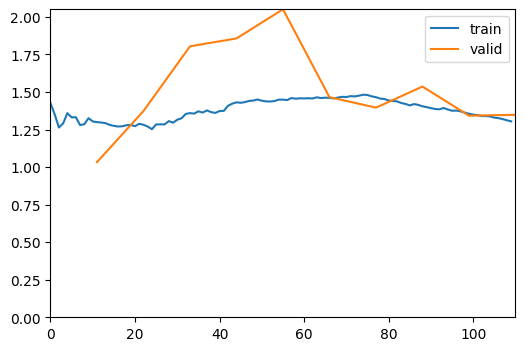

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


Path('models/_stage2.pth')

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

learner = getLearner(reload_data=False, saved_file=None, save_callback_flag=True,wd =config['weight_decay']) 
# 1cycle policy
learner.fit_one_cycle(n_epoch=10, lr_max=max_lr, wd=wd)
learner.load(config['model_str']+"_best_model")
learner.save("_stage1")
learner.fit_one_cycle(n_epoch=10, lr_max=max_lr, wd=wd)
learner.load(config['model_str']+"_best_model")
learner.save("_stage2")

In [20]:
learner.load("_stage2")
learner.save(config['model_str']+"_{}".format("stage_1_alt_high_loss"))


Path('models/xception/cross_entropy/mixup_stage_1_alt_high_loss.pth')

In [21]:
learner = getLearner(reload_data=False, saved_file=config['model_str'] + "_stage_1_alt_high_loss", save_callback_flag=True,wd = 1e-4)


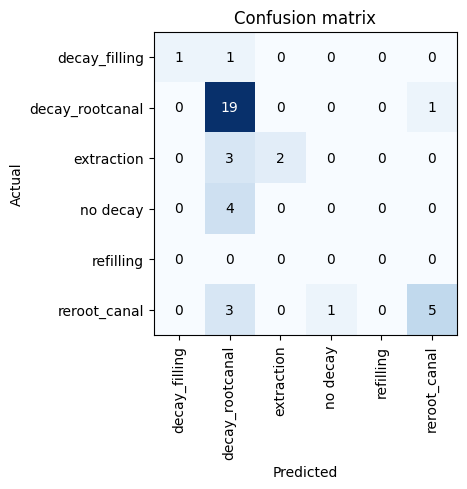

In [22]:
from fastai.interpret import ClassificationInterpretation

# Predict the validation set with your model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')



**FINETUNING**

In [23]:
finetune_run_name = config['model_str'] + "_finetune"

Find LR

SuggestedLRs(valley=0.00013803842011839151)

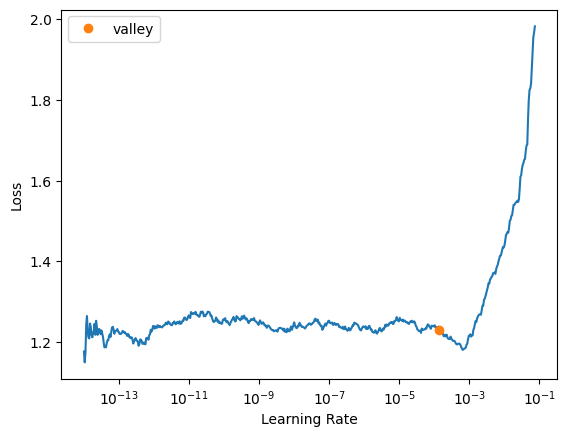

In [24]:
#load the baseline model
learner = getLearner(reload_data=False, saved_file=config['model_str'] + "_stage_1_alt_high_loss", save_callback_flag=True,wd = 1e-4)

#unfreeze and run the lr finder again
learner.unfreeze()
learner.lr_find( num_it=600, start_lr=1e-14, end_lr = 1e-1)


training

In [25]:

learner = getLearner(reload_data=False, saved_file=config['model_str'] + "_stage_1_alt_high_loss", save_callback_flag=True,wd = 1e-4)
learner.unfreeze()

In [26]:
# learner.fit_one_cycle(n_epoch=10, lr_max=slice(1e-12,1e-8))
# learner.load(config['model_str']+"_best_model")
# learner.save("_stage1")

In [27]:
# learner.load("_stage1")
# learner.save(config['model_str']+"_{}".format("ft_stage_1"))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,1.245499,1.041474,0.700000,0.663542,00:07
1,1.281972,1.051674,0.700000,0.655463,00:07
2,1.252570,1.036821,0.675000,0.643388,00:07
3,1.208391,1.057696,0.700000,0.678730,00:08
4,1.217517,1.062601,0.600000,0.576190,00:07
5,1.197721,1.056657,0.625000,0.588946,00:07
6,1.199207,1.056165,0.625000,0.606391,00:07
7,1.190661,1.062259,0.625000,0.600201,00:08
8,1.197427,1.071425,0.625000,0.606391,00:07
9,1.194507,1.055699,0.625000,0.606391,00:07


Better model found at epoch 0 with fbeta_score value: 0.6635416666666667.


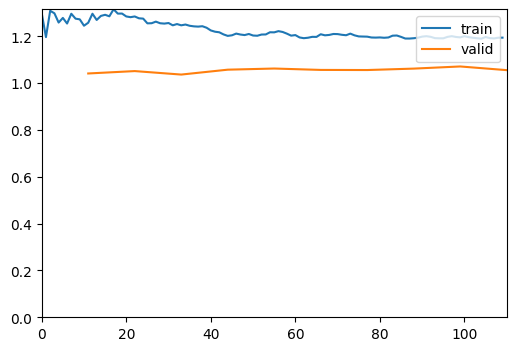

Better model found at epoch 3 with fbeta_score value: 0.6787297527706735.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


Path('models/_stage2.pth')

In [28]:
learner.fit_one_cycle(n_epoch=10, lr_max=slice(1e-8,1e-4))
learner.load(config['model_str']+"_best_model")
learner.save("_stage2")

In [29]:
learner.save("_stage2")

Path('models/_stage2.pth')

In [30]:
learner.load("_stage2")
learner.save(config['model_str']+"_{}".format("ft_stage_2"))

Path('models/xception/cross_entropy/mixup_ft_stage_2.pth')

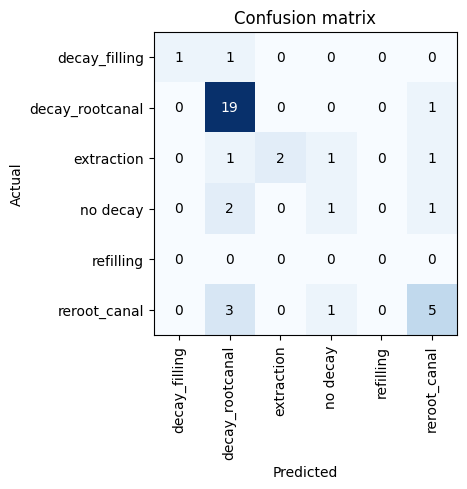

In [31]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [32]:
from fastai.vision.all import *

# Get interpretation object
interp = ClassificationInterpretation.from_learner(learner)

preds, y_true = learner.get_preds(dl=interp.dl)
y_preds = preds.argmax(dim=1)

class_names = learner.dls.vocab  
unique_classes = sorted(set(y_true.numpy()))  
filtered_class_names = [class_names[i] for i in unique_classes] 
report = classification_report(y_true.numpy(), y_preds.numpy(), target_names=filtered_class_names)
print(report)


                 precision    recall  f1-score   support

  decay_filling       1.00      0.50      0.67         2
decay_rootcanal       0.73      0.95      0.83        20
     extraction       1.00      0.40      0.57         5
       no decay       0.33      0.25      0.29         4
   reroot_canal       0.62      0.56      0.59         9

       accuracy                           0.70        40
      macro avg       0.74      0.53      0.59        40
   weighted avg       0.71      0.70      0.68        40



In [33]:
pickle_path = "/kaggle/working/mixup_best_model.pkl"
learner.export(pickle_path)
print(f"Model saved as: {pickle_path}")

Model saved as: /kaggle/working/mixup_best_model.pkl
